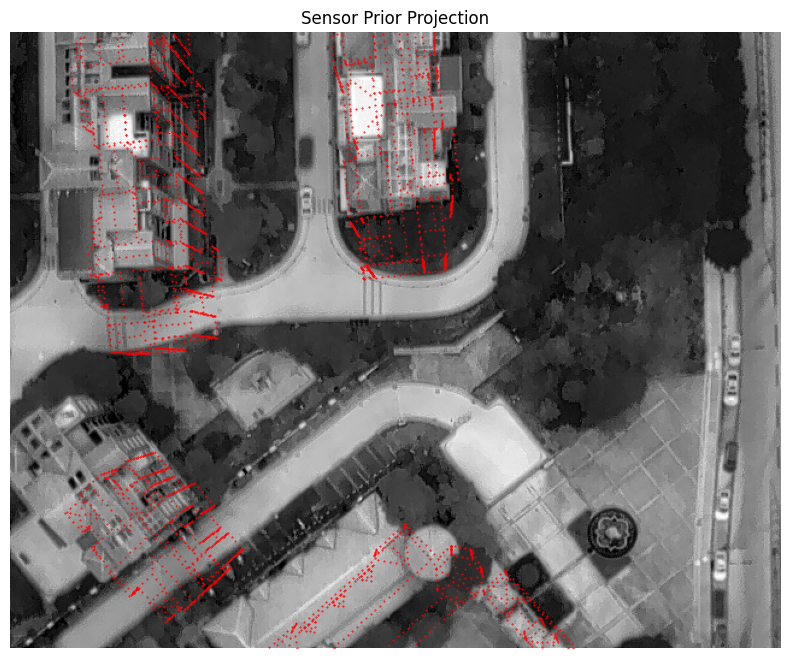

In [2]:
import numpy as np 
from pathlib import Path
import os
import matplotlib.pyplot as plt
from PIL import Image
from script.utils import point_proj

DEMO_data_dir = Path('dataset/DEMO/demo')
DEMO_data_name = 'DJI_20230513163714_0033_T.JPG'

q_pth = os.path.join(DEMO_data_dir , 'Query_image' , DEMO_data_name)
prior_pth = os.path.join(DEMO_data_dir , 'GPS_pose' , DEMO_data_name.split(".")[0]+"_pose.txt")
GT_pth = os.path.join(DEMO_data_dir , 'GT_pose' , DEMO_data_name.split(".")[0]+"_pose.txt")
intri_pth = os.path.join(DEMO_data_dir , 'intrinsic' , DEMO_data_name.split(".")[0]+'_intrinsic.txt')
points_pth = os.path.join(DEMO_data_dir , 'Points' , DEMO_data_name.split(".")[0]+'_points.npy')
save_pth = os.path.join(DEMO_data_dir , 'results')
mask_pth = os.path.join(DEMO_data_dir , 'Mask' , DEMO_data_name.split(".")[0]+".png")

points = np.load(points_pth)
pose = np.loadtxt(prior_pth)
intrin = np.loadtxt(intri_pth)

final_sampled_uv, _ = point_proj(points, pose, intrin)


image = Image.open(q_pth)

plt.figure(figsize=(10, 8))
plt.imshow(image) 

plt.scatter(final_sampled_uv[:, 0], final_sampled_uv[:, 1], color='red', marker='o', s=0.2, label='Points of Wireframe')

plt.title("Sensor Prior Projection")
plt.axis('off')
plt.savefig(os.path.join(save_pth, DEMO_data_name), dpi=300, bbox_inches='tight')
plt.show()

In [11]:
from omegaconf import OmegaConf
from maploc.data import DEMODataModule
from maploc.evaluation.run import evaluate_demo
model_overrides = {
    "model": {
        "name": 'LoD_Loc_mask',
        "lamb_val": [0.8,0.8,0.8],
        "num_sample_val": [[8, 10, 10, 30],[8, 10, 10, 30],[8, 10, 10, 30]]
    },
    "resize_image": [512, 640]
}
split = 'val'
multstage = 3
output_name = "demo_results"
data_cfg_demo = OmegaConf.load("maploc/conf/data/DEMO.yaml")
default_cfg_single = OmegaConf.create({"data": data_cfg_demo})

default = default_cfg_single
cfg = OmegaConf.merge(default_cfg_single, dict(model_overrides))

dataset = DEMODataModule(cfg.get("data", {}))
ckpt = "./dataset/DEMO/demo.ckpt"

save = evaluate_demo(ckpt, cfg, dataset, split, multstage=multstage, output_name=output_name)


[2024-04-16 11:12:32 maploc INFO] Evaluating model ./dataset/DEMO/demo.ckpt
[2024-04-16 11:12:32 maploc INFO] Using checkpoint demo.ckpt from epoch 53 and step 40000.
[2024-04-16 11:12:32 maploc INFO] Loading scene demo.
Seed set to 0
100%|██████████| 1/1 [00:00<00:00,  6.16it/s]


Save prediction to /home/ubuntu/code/texlessLoc/experiments/demo_results/pred


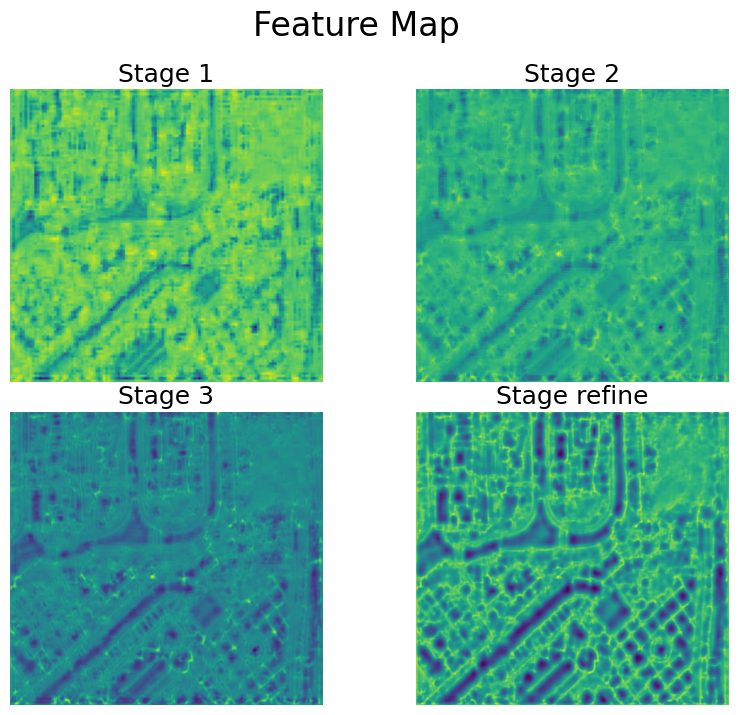

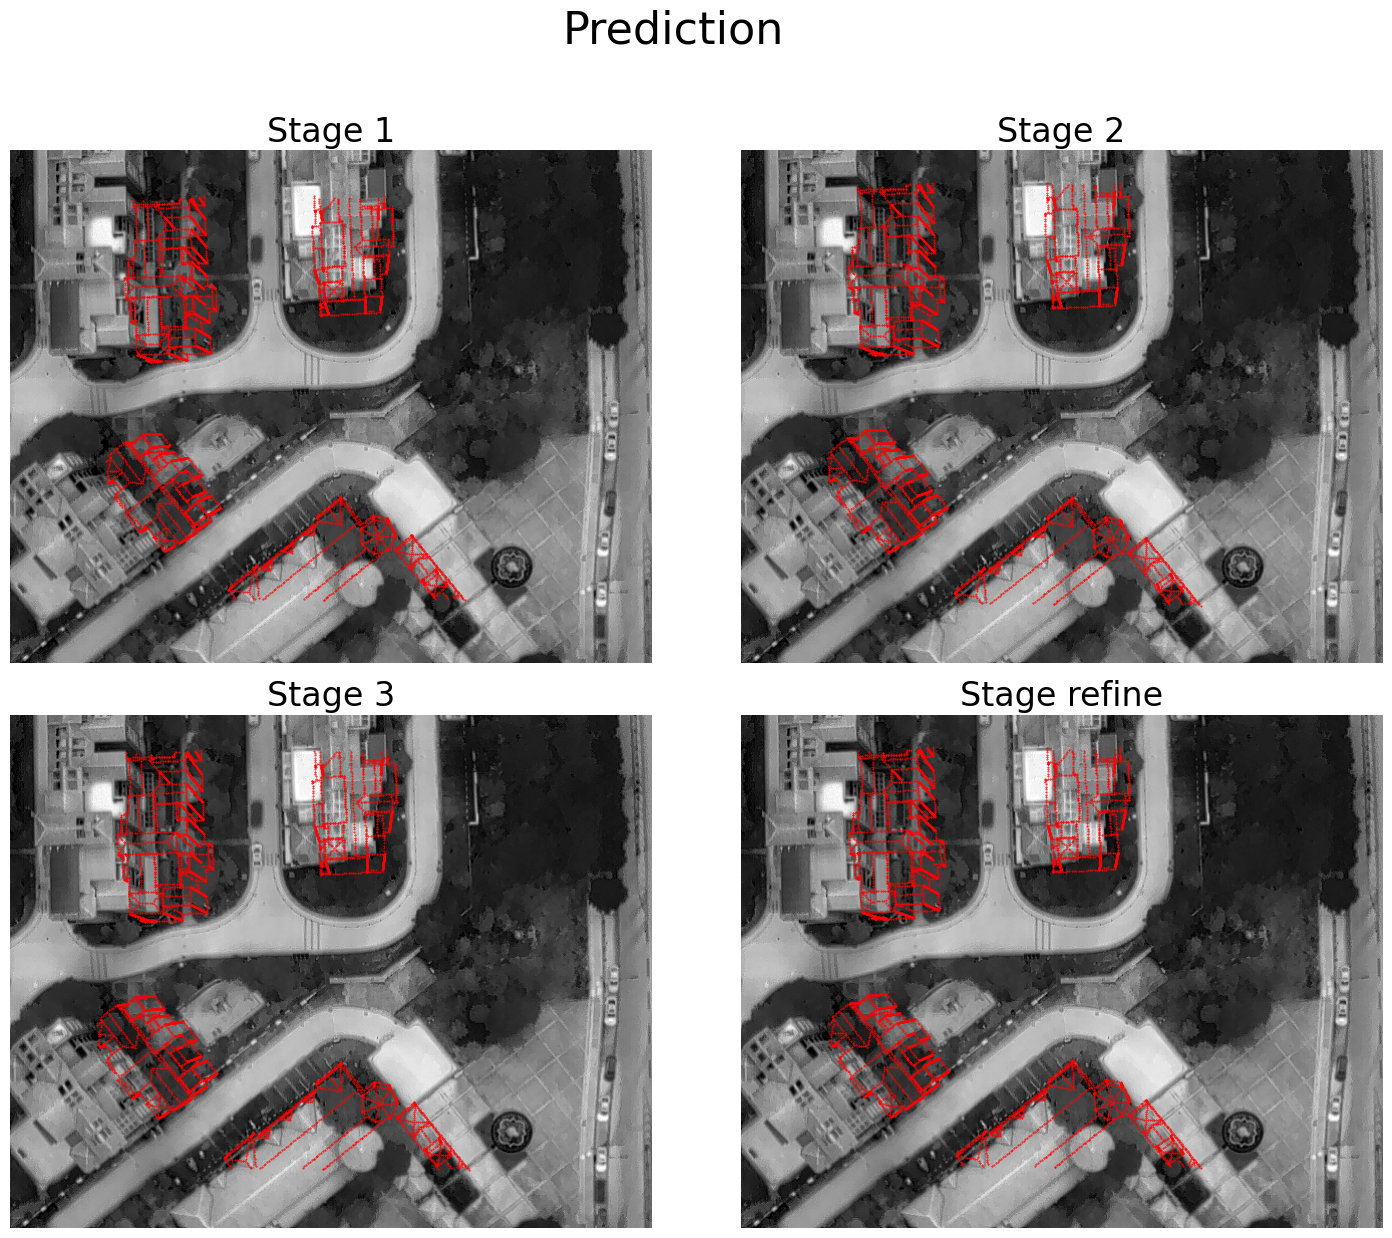

In [9]:
import torch
import torch.nn.functional as F

list_ = sorted(os.listdir(save))

points_poth_ = os.path.join(DEMO_data_dir , 'Points_GT' , DEMO_data_name.split(".")[0]+'_points.npy')
points_ = np.load(points_poth_)

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle('Feature Map', fontsize=24)
plt.subplots_adjust(hspace=0.1, wspace=0.1)
for item, axs_ in zip (list_, axs.flat): 

    feat_poth = os.path.join(save, item, DEMO_data_name.split('.')[0]+'.pth')
    feat = torch.load(feat_poth)

    if item == "refine":
        feat = -feat
        
    normalized_map = F.normalize(feat, p=2, dim=(0, 1))
    axs_.set_title("Stage {}".format(item), fontsize=18)
    axs_.imshow(normalized_map, cmap='viridis') 
    axs_.axis('off')


fig, axs = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Prediction', fontsize=32)
plt.subplots_adjust(hspace=0.1, wspace=0.1)
for item, axs_ in zip (list_, axs.flat):
    pose_poth = os.path.join(save, item, DEMO_data_name.split('.')[0]+'_pose.txt')
    pose = np.loadtxt(pose_poth)

    final_sampled_uv, _ = point_proj(points_, pose, intrin)
    image = Image.open(q_pth)
    axs_.imshow(image) 

    axs_.scatter(final_sampled_uv[:, 0], final_sampled_uv[:, 1], color='red', marker='o', s=0.2, label='Points of Wireframe')
    axs_.set_title("Stage {}".format(item), fontsize=24)
    axs_.axis('off')
